In [34]:
import pandas as pd
import numpy as np

In [35]:
df = pd.read_csv("all_props.csv", na_values=[""])


# Save to a CSV file
molecules = df['Symbol'].values


molecules = molecules
molecules

array(['Ge', 'Mg', 'B', 'Si', 'Cl', 'Mn', 'Pd', 'B', 'Hg', 'Mg', 'P',
       'Al', 'Mg', 'Sn', 'F', 'Pb', 'B', 'Br', 'Tl', 'Pd', 'Tl', 'U', 'I',
       'Ge', 'H', 'Ag', 'C', 'Ir', 'Mg', 'Mg', 'Cd', 'Al', 'Bi', 'Al',
       'F', 'Tl', 'Be', 'Pt', 'Pa', 'S', 'S', 'Hf', 'Be', 'Rh', 'Mg', 'B',
       'I', 'Mg', 'Ag', 'Zn', 'Au', 'Au', 'F', 'N', 'Fe', 'Mg', 'Mg',
       'Mg', 'As', 'S', 'Mg', 'Cl', 'In', 'Si', 'Mg', 'Mg', 'I', 'Sn',
       'N', 'Ga', 'Br', 'B'], dtype=object)

In [36]:
df.drop(columns=['Symbol','results_per_total','results_per_li'], inplace=True)

In [ ]:
df['Sqrt_pol'] = np.sqrt(df['Polarizability'])

### making the combinations

In [37]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

In [38]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]

            # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue

            # Select the subset DataFrame
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results


In [39]:
import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names, restricted_properties=None, restricted_to_inverses=None):
    if restricted_properties is None:
        restricted_properties = []
    if restricted_to_inverses is None:
        restricted_to_inverses = []

    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

     # Precompute invalid pairs (parameter and its inverse)
    invalid_pairs = {f"{name}^(-1)": name for name in param_names}
    invalid_pairs.update({name: f"{name}^(-1)" for name in param_names})
    
    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):
            subset_names = [combined_param_names[i] for i in subset_indices]

            # Replace NaN values with 0
             # Skip invalid subsets early
            if any(invalid_pairs.get(name) in subset_names for name in subset_names):
                continue
            
            subset = combined_params_df[subset_names]
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
           
            # Exclude subsets containing restricted inverses
            for restricted in restricted_properties:
                if f"{restricted}^(-1)" in subset_names:
                    invalid = True
                    break

            # Ensure restricted properties only appear as inverses
            for restricted in restricted_to_inverses:
                if restricted in subset_names or (restricted not in param_names and f"{restricted}^(-1)" not in subset_names):
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))
            expr_str = " + ".join(subset_names)
            expr_val = subset.sum(axis=1)
            results.append((expr_str, expr_val))

    return results


In [40]:
import itertools
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count

def process_combinations_chunk(args):
    combined_params_df, combined_param_names, param_names, indices_chunk = args
    results = []

    for indices in indices_chunk:
        subset_names = [combined_param_names[i] for i in indices]
        subset = combined_params_df[subset_names]

        # Replace NaN values with 0
        subset = subset.fillna(0)

        # Check if both a parameter and its inverse are in the subset
        invalid = False
        for name in subset_names:
            if name.endswith("^(-1)") and name[:-5] in subset_names:
                invalid = True
                break
            elif name in param_names and f"{name}^(-1)" in subset_names:
                invalid = True
                break

        if not invalid:
            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

def generate_combinations_df_parallel(params_df, param_names):
    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameter indices
    all_combinations = [
        indices for r in range(1, len(combined_param_names) + 1)
        for indices in itertools.combinations(range(len(combined_param_names)), r)
    ]

    # Divide all_combinations into chunks
    num_workers = min(cpu_count(), len(all_combinations))
    chunk_size = max(1, len(all_combinations) // num_workers)
    chunks = [all_combinations[i:i + chunk_size] for i in range(0, len(all_combinations), chunk_size)]

    print(f"Using {num_workers} workers to process {len(all_combinations)} combinations in {len(chunks)} chunks")

    # Prepare arguments for parallel processing
    args = [
        (combined_params_df, combined_param_names, param_names, chunk)
        for chunk in chunks
    ]

    # Use multiprocessing to process combinations in parallel
    with Pool(processes=num_workers) as pool:
        results = pool.map(process_combinations_chunk, args)

    # Flatten results
    flattened_results = [item for sublist in results for item in sublist]
    return flattened_results


### Running Combinations

In [41]:
# numeretor = ['Ion_C','Ion_A']
# denomeretor = ['Abs_diff_pol','Sum_pol','Abs_diff_EN','Sum_EN']
numeretor = None
denomeretor = None

In [42]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.columns)
    all_expressions = generate_combinations_df(df.iloc[:,:], param_names, restricted_properties=numeretor, restricted_to_inverses=denomeretor)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...


/var/folders/zp/h52np6n918qd9v9139ls4z600000gn/T/ipykernel_27904/1368268208.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


Expressions cached.
(4372, 2)


In [43]:
expressions['Value'] = expressions['Value'] 
expressions.head()

,Expression,Value
0,AtomicMass,0 72.630 1 24.305 2 10.810 3 ...
1,AtomicMass,0 72.630 1 24.305 2 10.810 3 ...
2,AtomicRadius,0 211.0 1 173.0 2 192.0 3 210....
3,AtomicRadius,0 211.0 1 173.0 2 192.0 3 210....
4,Electronegativity,0 2.01 1 1.31 2 2.04 3 1.90 4 ...


### Addition results to the combinations

In [44]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = pd.read_csv("all_props.csv", na_values=[""])['results_per_total'].values

In [45]:

correlation = values.corr()

correlation.shape

(4359, 4359)

In [46]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:100])
top_vars = results.iloc[1:100].index

res                                                                                                                    1.000000
Polarizability * AtomicRadius^(-1) * Electronegativity^(-1)                                                            0.554673
AtomicRadius^(-1) * Electronegativity^(-1) * IonizationEnergy^(-1)                                                     0.551385
Polarizability * AtomicRadius^(-1) * Electronegativity^(-1) * IonizationEnergy^(-1)                                    0.551162
IonizationEnergy * Polarizability * AtomicRadius^(-1) * Electronegativity^(-1)                                         0.542275
                                                                                                                         ...   
IonizationEnergy + Polarizability + AtomicMass^(-1) + AtomicRadius^(-1) + ElectronAffinity^(-1) + LiSites^(-1)         0.470864
IonizationEnergy + Polarizability + AtomicMass^(-1) + ElectronAffinity^(-1) + LiSites^(-1)              

In [47]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:200])
top_vars = results.iloc[1:200].index


res                                                                                                                      1.000000
Polarizability * AtomicRadius^(-1) * Electronegativity^(-1)                                                              0.554673
AtomicRadius^(-1) * Electronegativity^(-1) * IonizationEnergy^(-1)                                                       0.551385
Polarizability * AtomicRadius^(-1) * Electronegativity^(-1) * IonizationEnergy^(-1)                                      0.551162
IonizationEnergy * Polarizability * AtomicRadius^(-1) * Electronegativity^(-1)                                           0.542275
                                                                                                                           ...   
Polarizability + LiSites + AtomicRadius^(-1) + Electronegativity^(-1) + IonizationEnergy^(-1)                            0.466980
Polarizability + LiSites + Electronegativity^(-1) + IonizationEnergy^(-1)                 

In [48]:
param = top_vars[0]

y = values[param]
x = values['res']

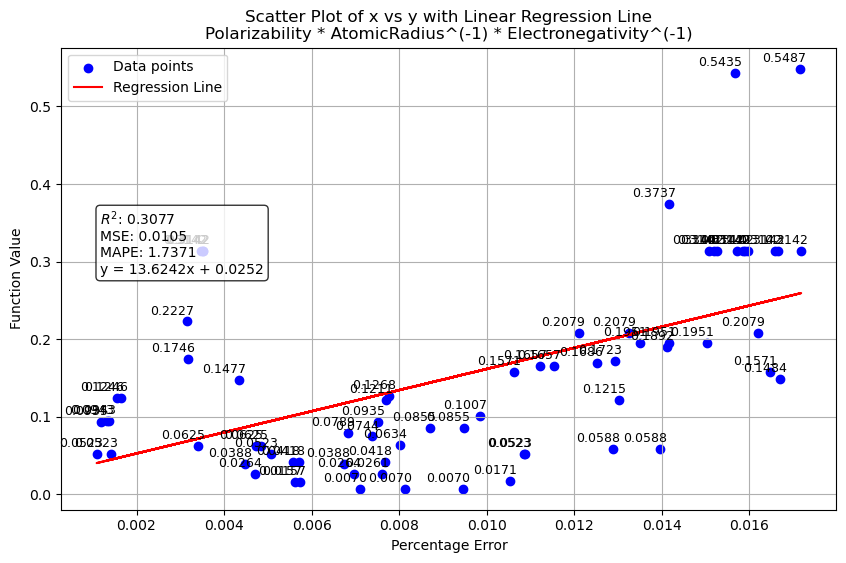

In [49]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Calculate R^2, MSE, and MAPE
r_squared = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line\n{param}')
plt.xlabel('Percentage Error')
plt.ylabel('Function Value')
plt.grid()
plt.legend()

for i in range(len(x)):
    plt.annotate(f"{y.iloc[i]:.4f}", (x.iloc[i], y.iloc[i]), textcoords="offset points", xytext=(5,5), ha='right', fontsize=9)

# Add text box with metrics
textstr = f"$R^2$: {r_squared:.4f}\nMSE: {mse:.4f} \nMAPE: {mape:.4f}\n{equation}"
plt.gca().text(0.05, 0.65, textstr, transform=plt.gca().transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.show()